- This study focus in analysing the relation of inflation in Brazil, with *SOME* of the main factors, for the lack of reliable datasets to support all the causations, accordingly with economics theory, and to keep the attention in the main indexes.
- Factors used: 
Interest Rate (IR); 
Money Supply (MS); 
Minimum Wages (MW); 
General Government Debt (GD); 
partial inflation rates that forms the final index (Inflation aggregates). All Datasets was downloaded from the Central Bank of Brazil.   


## Data Preprocessing

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split 

pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 20)

In [3]:
# Importing the Datasets
ir = pd.read_csv('IR.csv', sep=';', encoding='latin-1')
ms = pd.read_csv('MS.csv', sep=';', encoding='latin-1', thousands='.')
mw = pd.read_csv('MW.csv', sep=';', encoding='latin-1', thousands='.')
gd = pd.read_csv('GD.csv', sep=';', encoding='latin-1', thousands='.')
inflation = pd.read_csv('INFLATION.csv', sep=';', encoding='latin-1')

In [4]:
# Renaming the Columns
ir.rename(columns = {'Data':'date', "4390 - Taxa de juros - Selic acumulada no mês - % a.m.":'int_rate'}, inplace=True)

ms.rename(columns = {'Data':'date', "1786 - BM - Papel moeda emitido (saldo em final de período) - u.m.c. (mil)":
                     'money_supply'}, 
                      inplace=True)

mw.rename(columns = {'Data':'date', "1619 - Salário mínimo - u.m.c.":'min_wages'}, 
                      inplace=True)

gd.rename(columns = {'Data':'date', "4501 - Divida líquida do governo geral - Saldos em R$ milhões - R$ (milhões)":
                     'gov_debt'}, 
                     inplace=True)

inflation.rename(columns = {'Data':'date', 
                  
                 '433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal':'inflation',
                   
                 '1635 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Alimentação e bebidas - Var. % mensal':
                 'food',
                   
                 '1636 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Habitação - Var. % mensal':'housing',
                   
                 '1637 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Artigos de residência - Var. % mensal':
                 'house_items',
                   
                 '1638 - Índice nacional de preços ao consumidor-Amplo (IPCA)- Vestuário - Var. % mensal':'clothing',
                   
                 '1639 - Índice de nacional de preços ao consumidor-Amplo (IPCA) - Transportes - Var. % mensal':
                 'transport',
                  
                 '1640 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Comunicação - Var. % mensal':
                 'communication',
                   
                 '1641 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Saúde e cuidados pessoais - Var. % mensal':
                 'health',
                   
                 '1642 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Despesas pessoais - Var. % mensal':
                 'personal',
                   
                 '1643 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Educação - Var. % mensal': 'education'},
                 inplace=True)

In [5]:
# Merging all datasets into one, called 'merge3'
merged = inflation.merge(ir, on='date')
merged1 = merged.merge(ms, on='date')
merged2 = merged1.merge(mw, on='date') 
merged3 = merged2.merge(gd, on='date')

In [6]:
# Changing the dates to datetime format
merged3['date'] = pd.to_datetime(merged3['date'])

# Cropping the period from January/2000 to October/2021
mask = (merged3['date'] >= '2000-01-01') & (merged3['date'] <= '2021-10-1')
merged3 = merged3.loc[mask]
merged3.reset_index(drop=True, inplace=True)

# Save adjusted dataset 
merged3.to_csv('inflation_factors.csv', index=False)
inflation_factors = pd.read_csv('inflation_factors.csv', thousands='.', decimal=',')

inflation_factors

,date,inflation,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,money_supply,min_wages,gov_debt
0,2000-01-01,0.62,0.84,0.19,0.43,0.21,0.39,1.82,0.59,0.12,3.05,1.46,24199689,136.00,492136.23
1,2000-02-01,0.13,-0.25,0.01,0.29,-0.67,0.40,0.04,0.22,0.36,1.32,1.45,23068674,136.00,494285.94
2,2000-03-01,0.22,-0.46,0.17,0.28,-1.44,1.68,0.07,0.27,-0.07,-0.26,1.45,22732484,136.00,493089.13
3,2000-04-01,0.42,-0.36,0.00,0.19,0.72,0.51,-0.29,0.07,3.55,0.01,1.30,23279829,151.00,500897.64
4,2000-05-01,0.01,-0.67,0.45,0.25,0.35,0.13,0.18,0.03,0.13,0.07,1.49,22470333,151.00,505608.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2021-06-01,0.53,0.43,1.10,1.09,1.21,0.41,-0.12,0.51,0.29,0.05,0.31,340095553,1100.00,5133428.61
258,2021-07-01,0.96,0.60,3.10,0.78,0.53,1.52,0.12,-0.65,0.45,0.18,0.36,343812587,1100.00,5191114.72
259,2021-08-01,0.87,1.39,0.68,0.99,1.02,1.46,0.23,-0.04,0.64,0.28,0.43,341302698,1100.00,5212554.57
260,2021-09-01,1.16,1.02,2.56,0.90,0.31,1.82,0.07,0.39,0.56,-0.01,0.44,336844324,1100.00,5262849.94


 ## EDA


In [7]:
inflation_factors.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           262 non-null    object 
 1   inflation      262 non-null    float64
 2   food           262 non-null    float64
 3   housing        262 non-null    float64
 4   house_items    262 non-null    float64
 5   clothing       262 non-null    float64
 6   transport      262 non-null    float64
 7   communication  262 non-null    float64
 8   health         262 non-null    float64
 9   personal       262 non-null    float64
 10  education      262 non-null    float64
 11  int_rate       262 non-null    float64
 12  money_supply   262 non-null    int64  
 13  min_wages      262 non-null    float64
 14  gov_debt       262 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 45.9 KB


In [8]:
inflation_factors.describe()

,inflation,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,money_supply,min_wages,gov_debt
count,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00
mean,0.51,0.61,0.56,0.30,0.43,0.47,0.32,0.50,0.56,0.55,0.96,141142973.18,570.75,1913657.79
std,0.39,0.83,0.70,0.54,0.57,0.88,1.11,0.41,0.45,1.33,0.40,91219940.13,304.50,1305104.17
min,-0.38,-1.07,-2.38,-1.37,-1.44,-2.66,-1.65,-0.71,-0.25,-3.47,0.13,22470333.00,136.00,492136.23
25%,0.26,0.07,0.23,-0.03,0.08,-0.03,-0.01,0.32,0.29,0.04,0.68,55632399.25,300.00,970264.49
50%,0.45,0.58,0.48,0.29,0.47,0.34,0.07,0.43,0.50,0.13,0.94,133103061.00,510.00,1481819.22
75%,0.69,1.03,0.77,0.56,0.85,0.78,0.28,0.64,0.71,0.35,1.23,205271965.00,880.00,2484994.07
max,3.02,5.85,5.29,2.88,1.91,4.68,9.31,2.74,3.55,6.70,2.08,370441036.00,1100.00,5289723.28


## Data Splits

In [9]:
    # Label split
    label = inflation_factors[['inflation']]
    label

,inflation
0,0.62
1,0.13
2,0.22
3,0.42
4,0.01
...,...
257,0.53
258,0.96
259,0.87
260,1.16


In [10]:
# Features split
features_to_scale = inflation_factors.iloc[:, 2:]
features_to_scale

,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,money_supply,min_wages,gov_debt
0,0.84,0.19,0.43,0.21,0.39,1.82,0.59,0.12,3.05,1.46,24199689,136.00,492136.23
1,-0.25,0.01,0.29,-0.67,0.40,0.04,0.22,0.36,1.32,1.45,23068674,136.00,494285.94
2,-0.46,0.17,0.28,-1.44,1.68,0.07,0.27,-0.07,-0.26,1.45,22732484,136.00,493089.13
3,-0.36,0.00,0.19,0.72,0.51,-0.29,0.07,3.55,0.01,1.30,23279829,151.00,500897.64
4,-0.67,0.45,0.25,0.35,0.13,0.18,0.03,0.13,0.07,1.49,22470333,151.00,505608.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.43,1.10,1.09,1.21,0.41,-0.12,0.51,0.29,0.05,0.31,340095553,1100.00,5133428.61
258,0.60,3.10,0.78,0.53,1.52,0.12,-0.65,0.45,0.18,0.36,343812587,1100.00,5191114.72
259,1.39,0.68,0.99,1.02,1.46,0.23,-0.04,0.64,0.28,0.43,341302698,1100.00,5212554.57
260,1.02,2.56,0.90,0.31,1.82,0.07,0.39,0.56,-0.01,0.44,336844324,1100.00,5262849.94


In [11]:
features_to_scale.dtypes

food             float64
housing          float64
house_items      float64
clothing         float64
transport        float64
communication    float64
health           float64
personal         float64
education        float64
int_rate         float64
money_supply       int64
min_wages        float64
gov_debt         float64
dtype: object

## Scaling

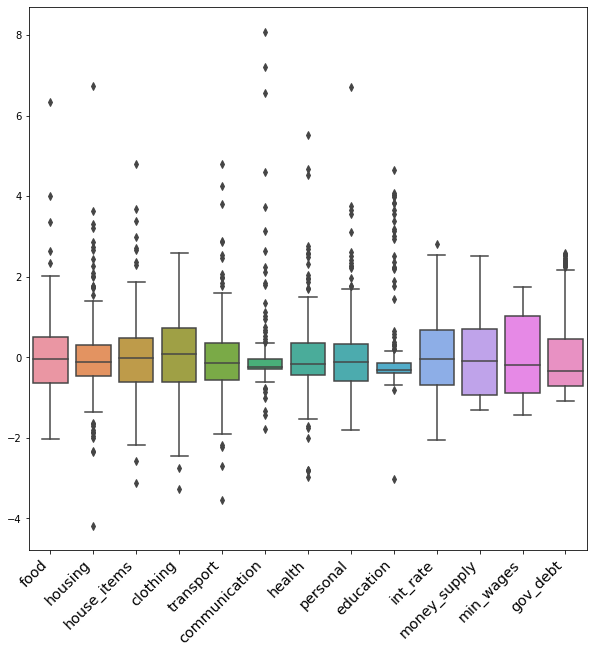

In [12]:
# Scaling Features
scaling = StandardScaler()
features_scaled = scaling.fit_transform(features_to_scale)


# ndarray to DataFrame
features_names = (['food', 'housing', 'house_items', 'clothing', 'transport',
                   'communication', 'health', 'personal', 'education', 'int_rate',
                   'money_supply', 'min_wages', 'gov_debt'])

features = pd.DataFrame(features_scaled, columns=features_names, dtype=(float))


# Distributions of Features
plt.figure(figsize=(10,10))
plt.xticks(rotation=45, horizontalalignment='right', fontsize='x-large')
sns.boxplot(data=features)

None # dont show the label objects

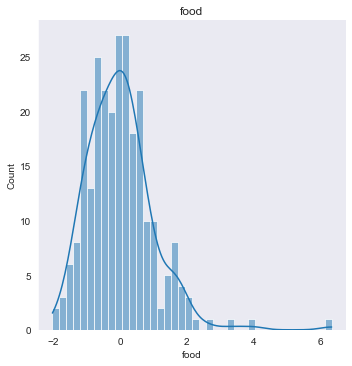

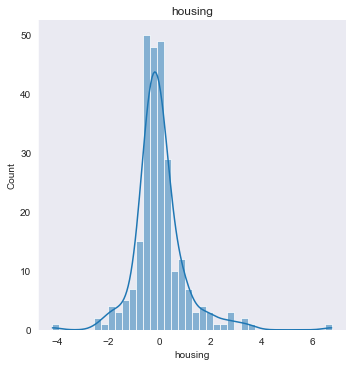

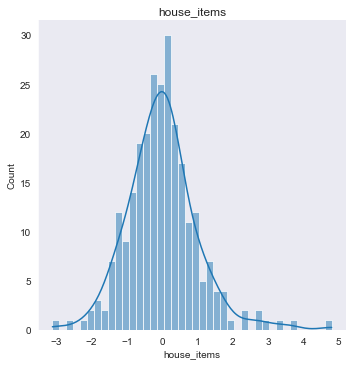

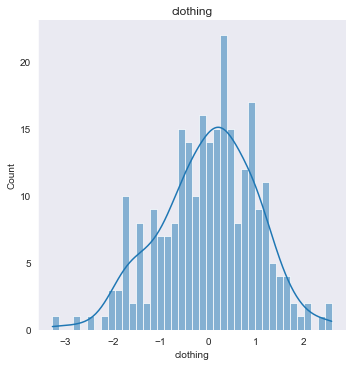

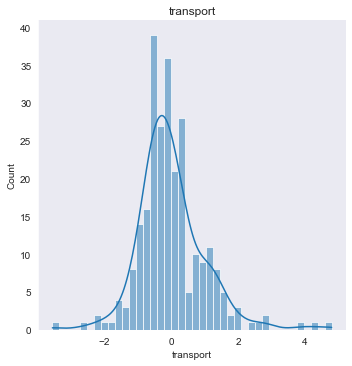

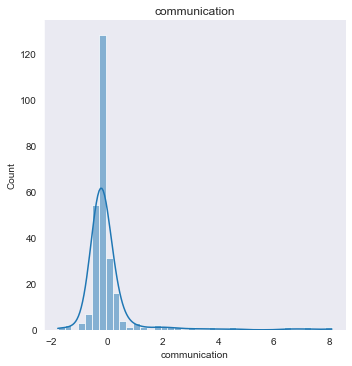

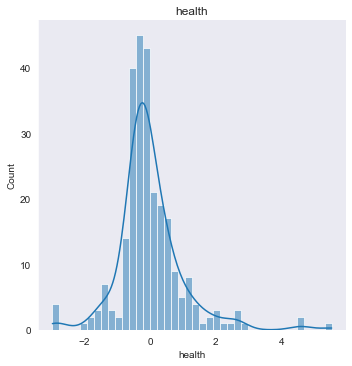

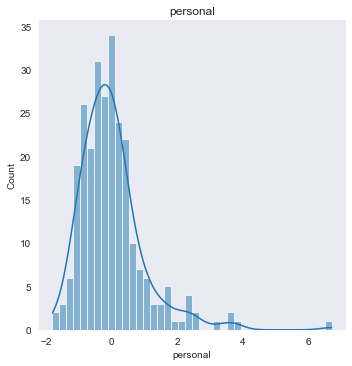

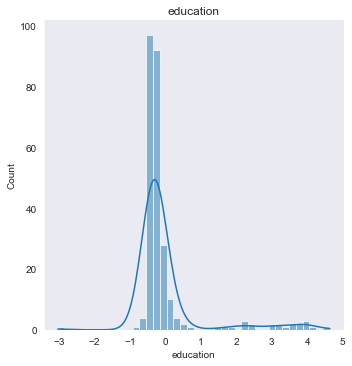

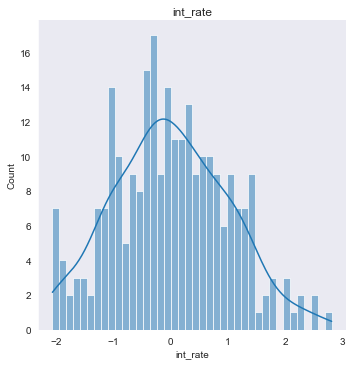

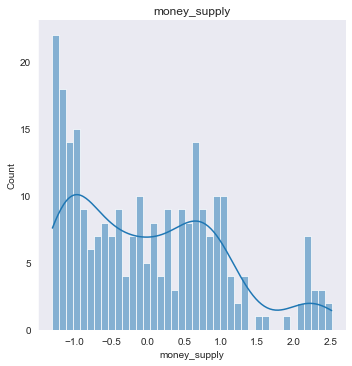

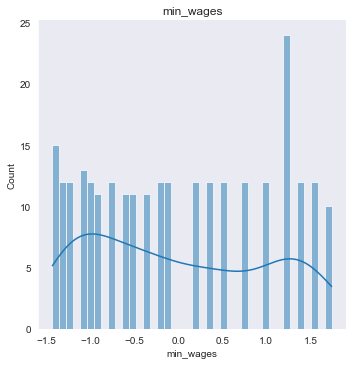

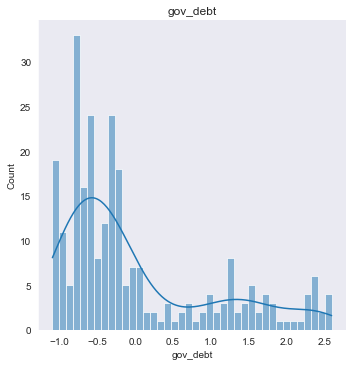

In [13]:
# Histogram of each Feature
for columns in features.columns:
    sns.set_style('dark')
    sns.displot(data=features[columns], kde=True, bins=40, height=5, aspect=1)
    plt.title(columns)
    plt.show(columns)

<AxesSubplot:>

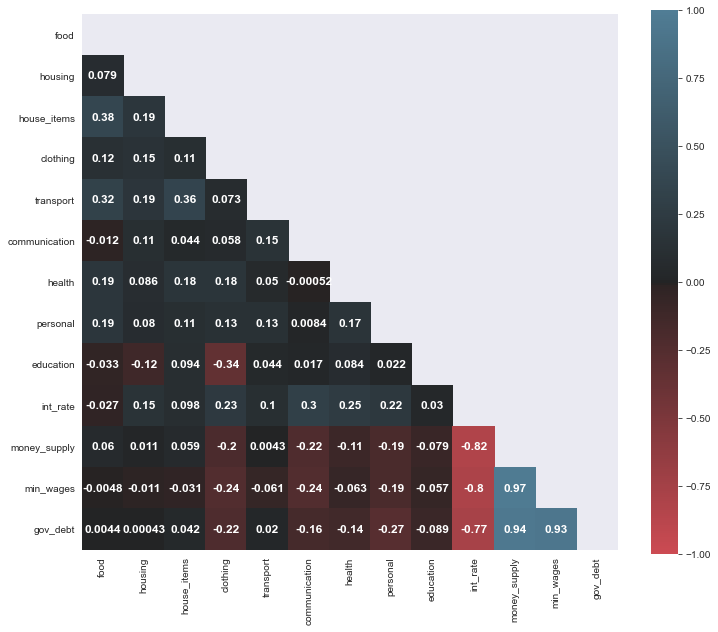

In [14]:
# Correlations map
mask = np.triu(np.ones_like(features.corr()))
cmap = sns.diverging_palette(10, 230, as_cmap=True, center="dark", s=60)

plt.figure(figsize=(12,10))

sns.heatmap(features.corr(), cmap=cmap, square=True, center=0, vmin=-1, vmax=1, 
            annot=True, mask=mask, annot_kws={'fontsize':12, 'fontweight':'bold'})

In [15]:
# Train-Test Split definition
features_train, features_test, label_train, label_test = train_test_split(features, label, train_size= 0.1 ,
                                                                          random_state=1)

In [16]:
print(label_train)

     inflation
50        0.47
142       0.52
157       0.60
156       0.86
234       0.19
..         ...
203       0.30
255       0.31
72        0.59
235       0.11
37        1.57

[26 rows x 1 columns]


## Modeling

In [17]:
# Regression Model 
model = linear_model.LinearRegression() # defines the regression Model
model.fit(features_train, label_train) # build training model
label_pred = model.predict(features_test) # apply trained model to predict

In [18]:
# Prediction Results
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.4f' % mean_squared_error(label_test, label_pred))
print('Coefficient of determination (R^2): %.4f' % r2_score(label_test, label_pred))

Coefficients: [[ 0.19342396  0.12162185  0.0256631   0.03638993  0.18596409  0.02311741
   0.03648919  0.0580779   0.08414158  0.00143259  0.03357395 -0.03607405
   0.01741359]]
Intercept: [0.51202977]
Mean squared error (MSE): 0.0021
Coefficient of determination (R^2): 0.9869


In [19]:
# Contribution of each feature  

coefficients = {'Factors':['food', 'housing', 'house_items', 'clothing', 'transport', 'communication', 'health', 
                           'personal', 'education', 'int_rate', 'money_supply', 'min_wages', 'gov_debt'],
                 'Coeffs':[0.19342396, 0.12162185, 0.0256631, 0.03638993, 0.18596409, 0.02311741, 0.03648919, 
                           0.0580779, 0.08414158, 0.00143259, 0.03357395, -0.03607405, 0.01741359]}
      
contribution = pd.DataFrame(coefficients)
pd.set_option('float_format', '{:.4f}'.format)         
        
contribution = contribution.sort_values(by='Coeffs', ascending=False).style.hide_index()
contribution

Factors,Coeffs
food,0.193424
transport,0.185964
housing,0.121622
education,0.084142
personal,0.058078
health,0.036489
clothing,0.036390
money_supply,0.033574
house_items,0.025663
communication,0.023117


In [20]:
# Plot comparing the distributions of Target values with the Predicted values 
plt.figure(figsize=(7,7))
sns.scatterplot(x=label_test, y=label_pred, alpha=.5, s=400)

ValueError: If using all scalar values, you must pass an index

<Figure size 504x504 with 0 Axes>